
We are going to implement a classification algorithm with a Feed Forward Fully Connected Neural Network, also called Multi Layer Perceptron (MLP).  

In [1]:
%matplotlib inline  

import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import operator
import warnings
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# this function takes col category and returns as Y (target), the other columns are X (labels)
def split_X_Y(data):
    Y = data['category']
    X = data.drop('category',axis=1)

    return X,Y

# this function divides the dataset in input in parts_to_be_split parts. One of them is returned as test_set
# the other ones are the training_set. Indexes of the chosen data can be accessed (test_indexes, train_indexes)
# (for example in a K-fold)

def split_train_test_set(data,parts_to_be_split):
    indexes = np.arange(0,data.shape[0],1)
    rnd.shuffle(indexes)
    len_test_set = int(len(indexes) / parts_to_be_split)

    test_indexes = indexes[:len_test_set]
    train_indexes = indexes[len_test_set:]

    train_set = data.iloc[train_indexes]
    test_set = data.iloc[test_indexes]
    
    return train_set, test_set

In [3]:
file_name="magic04.data"    #"/home/samu/LaboratoryOfComputationalPhysics_Y7/Project/magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']



train_set, test_set = split_train_test_set(data,5)
X_train,Y_train = split_X_Y(train_set)
X_test,Y_test = split_X_Y(test_set)
Y_train = np.array(np.where(Y_train == 'g', 1, -1))
Y_test  = np.array(np.where(Y_test == 'g', 1, -1))

print('shape of train_set:',np.shape(X_train),np.shape(Y_train))
print('shape of train_set:',np.shape(X_test),np.shape(Y_test))
print(X_train,Y_train)


shape of train_set: (15216, 10) (15216,)
shape of train_set: (3803, 10) (3803,)
        fLength   fWidth   fSize   fConc  fConc1    fAsym   fM3Long  fM3Trans  \
10519   19.9263  16.7442  2.6698  0.4171  0.2107   0.3877   -8.6963   12.5462   
15549   24.2438  15.9060  2.6006  0.3890  0.2661 -15.7870   36.2131   -9.9236   
17727  178.3754  48.6087  3.8877  0.1557  0.0918 -76.4010 -165.0751   -7.0248   
18985   26.9117   9.5105  2.5264  0.4853  0.2579  -2.6274   18.2372    5.1675   
17894  157.6720  58.5786  3.9945  0.1078  0.0561 -70.9062 -122.0640  -40.4482   
...         ...      ...     ...     ...     ...      ...       ...       ...   
11834   34.4505   9.7234  2.5145  0.5138  0.2859  36.3998   31.0299    5.9910   
11751   22.4940  12.1301  2.3856  0.6132  0.3560  18.5438   13.4683  -10.1801   
2264    26.2244  13.1076  2.6390  0.4478  0.2698  10.4659   14.4842   -9.4439   
11288   36.2456   8.6724  2.3064  0.4840  0.2593  22.0049   22.7257    1.0619   
15179   42.4086  12.0910  2.6

We choose the RELU activation function for the hidden layers (most frequent choice) and the Stochastic Gradient Descent method to compute the weights with Backpropagation. Thus, the hyper-parameters of the hypothesis class we have to tune are the **architecture of the network** (number of hidden layers and neurons in each hidden layer) and the **learning rate**. We implement a grid search to find the combination of these parameters that maximizes the partial area under the ROC curve, up until a false positive rate FPR $\le$ 0.2.      

In [4]:
###### first method


parameters = {'hidden_layer_sizes': [(18,), (36,), (54), (36,18), (54,18), (54,36), (54,36,18)],'learning_rate_init': [0.1,0.01,0.001]}

MLP=MLPClassifier(activation = 'relu', max_iter = 300, alpha = 1e-4, solver = 'sgd',tol = 1e-4, learning_rate = 'adaptive')

# this function determines the partial area under the curve, up to FPR<=0.2
def partial_auc_at_fpr(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    valid_indices = fpr <= 0.2  # indices where FPR <= 0.2
    partial_fpr = fpr[valid_indices]
    partial_tpr = tpr[valid_indices]
    # check if there are at least 2 points for partial AUC calculation
    if len(partial_fpr) < 2:
        return 0  # return 0 if not enough points to calculate AUC

    partial_auc = auc(partial_fpr, partial_tpr)
    return partial_auc

# create scoring function (partial AUC) to implement a grid-search
partial_auc_scorer = make_scorer(partial_auc_at_fpr, greater_is_better=True)

# to print the results after each combination is evaluated
class VerboseGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        super()._run_search(evaluate_candidates)
        
        # print the partial AUC after each parameter evaluation
        for i, params in enumerate(self.cv_results_['params']):
            mean_score = self.cv_results_['mean_test_score'][i]
            print(f"Parameters: {params} - Partial AUC: {mean_score}")

# implement the grid-search to maximize the partial AUC (5-fold cross-validation)
grid_search = VerboseGridSearchCV(estimator=MLP, param_grid=parameters, scoring=partial_auc_scorer, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_,)
print("Best partial AUC (Training set):", grid_search.best_score_)

# evaluate the best model on the test set and plot its ROC curve
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[fpr <= 0.2]
test_partial_auc = auc(partial_fpr, partial_tpr)
print("Best partial AUC (Test set):", test_partial_auc)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

AttributeError: 'VerboseGridSearchCV' object has no attribute 'cv_results_'

In [5]:
################# alternative method   ###############


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definizione degli iperparametri da testare
parameters = {'hidden_layer_sizes': [(18,), (36,), (54,), (36,18), (54,18), (54,36), (54,36,18)],
              'learning_rate_init': [0.1,0.01,0.001]}

# Creazione del classificatore MLP
MLP = MLPClassifier(activation='relu', max_iter=600, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate='adaptive')


#### partial auc scorer
def partial_auc_scorer(y_true, y_pred_proba, fpr_threshold=0.2):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    partial_fpr = fpr[fpr <= fpr_threshold]
    partial_tpr = tpr[:len(partial_fpr)]
    return auc(partial_fpr, partial_tpr)


#### full auc scorer
def full_auc_scorer(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return auc(fpr, tpr)

auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict' ) 
### need_proba si gonna be deprecated, substituted with response_method='predict' for same results

partial_auc_scorer_func = make_scorer(partial_auc_scorer, greater_is_better=True, response_method='predict')


## to print the results after each combination is evaluated
class VerboseGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        super().fit(X, y, **fit_params)  # Esegue la ricerca a griglia normalmente

        for i, params in enumerate(self.cv_results_['params']):
            mean_score = self.cv_results_['mean_test_score'][i]
            print(f"Parameters: {params} - AUC: {mean_score}")
            
## implement the grid-search to maximize the partial AUC (5-fold cross-validation)
grid_search = VerboseGridSearchCV(estimator=MLP, param_grid=parameters, scoring=auc_scorer, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC (Training set):", grid_search.best_score_)

#### partial AUC  and best model

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  


fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
auc_value = auc(fpr, tpr)
print("AUC (Test set):", auc_value)

partial_fpr = fpr[fpr <= 0.2]

# check that auc is computable (set to zero if it is not)
if(len(partial_fpr < 2)):
    partial_tpr = tpr[:len(partial_fpr)]
    partial_auc = auc(partial_fpr, partial_tpr)
else:
    partial_auc = 0
print("Partial AUC (Test set, FPR<=0.2):", partial_auc)



Fitting 5 folds for each of 21 candidates, totalling 105 fits


/usr/lib/python3/dist-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/lib/python3/dist-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Parameters: {'hidden_layer_sizes': (18,), 'learning_rate_init': 0.1} - AUC: 0.5030492846311848
Parameters: {'hidden_layer_sizes': (18,), 'learning_rate_init': 0.01} - AUC: 0.7582933339244755
Parameters: {'hidden_layer_sizes': (18,), 'learning_rate_init': 0.001} - AUC: 0.7902007692562727
Parameters: {'hidden_layer_sizes': (36,), 'learning_rate_init': 0.1} - AUC: 0.5475423243178232
Parameters: {'hidden_layer_sizes': (36,), 'learning_rate_init': 0.01} - AUC: 0.7804398596403137
Parameters: {'hidden_layer_sizes': (36,), 'learning_rate_init': 0.001} - AUC: 0.7869150299343571
Parameters: {'hidden_layer_sizes': (54,), 'learning_rate_init': 0.1} - AUC: 0.5528611972204961
Parameters: {'hidden_layer_sizes': (54,), 'learning_rate_init': 0.01} - AUC: 0.7808351067000474
Parameters: {'hidden_layer_sizes': (54,), 'learning_rate_init': 0.001} - AUC: 0.7911469172827397
Parameters: {'hidden_layer_sizes': (36, 18), 'learning_rate_init': 0.1} - AUC: 0.5017517869481448
Parameters: {'hidden_layer_sizes': (36

In [27]:
# redefine NN cycle
hidden_layer_sizes = [(18,), (36,), (54,), (36,18), (54,18), (54,36), (54,36,18)]
learning_rate_init = [ 0.1 , 0.01 , 0.001 ]

start_time = time()

auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict' ) 

parameters = []
fprs = []
tprs = []
aucs = []
partial_aucs = []
hls = []
lrs = []

for size in hidden_layer_sizes:
    for lr in learning_rate_init:
        print(f"Training MLP of size {size} and lr {lr}...")
        lrs.append(lr)
        hls.append(size)
        
        MLP = MLPClassifier(hidden_layer_sizes=size,
                            activation='relu', 
                            max_iter=600, 
                            alpha=1e-4, 
                            solver='sgd', 
                            tol=1e-4, 
                            learning_rate='adaptive',
                            learning_rate_init=lr,
                            verbose=0)
        
        MLP.fit(X_train,Y_train)
        parameters.append(MLP.coefs_)
        
        elapsed_time = time() - start_time
        start_time = time()
        
        y_pred_proba = MLP.predict_proba(X_test)[:, 1]  

        fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        auc_value = auc(fpr, tpr)
        aucs.append(auc_value)
        print("AUC (Test set):", auc_value)
        #print(fpr)
        
        # search for fpr less than 0.2 (if not able fpr is set to zero)
        partial_fpr = fpr[fpr <= 0.2]
        if (len(partial_fpr) < 2 ):
            partial_auc = 0
        else:
            partial_tpr = tpr[:len(partial_fpr)]
            partial_auc = auc(partial_fpr, partial_tpr)
        partial_aucs.append(partial_auc)
        
        print(f"Time needed for training: {elapsed_time:.2f} seconds")
        print("partial AUC:",partial_auc," total AUC:",auc_value,'\n')


Training MLP of size (18,) and lr 0.1...
AUC (Test set): 0.5001873403524341
Time needed for training: 4.27 seconds
partial AUC: 0  total AUC: 0.5001873403524341 

Training MLP of size (18,) and lr 0.01...
AUC (Test set): 0.8176654557331386
Time needed for training: 5.65 seconds
partial AUC: 0.07223449589114539  total AUC: 0.8176654557331386 

Training MLP of size (18,) and lr 0.001...
AUC (Test set): 0.8733782580428481
Time needed for training: 7.30 seconds
partial AUC: 0.10501197067876983  total AUC: 0.8733782580428481 

Training MLP of size (36,) and lr 0.1...
AUC (Test set): 0.500199203187251
Time needed for training: 4.31 seconds
partial AUC: 0.0  total AUC: 0.500199203187251 

Training MLP of size (36,) and lr 0.01...
AUC (Test set): 0.8438308637068124
Time needed for training: 3.08 seconds
partial AUC: 0.08335967807039435  total AUC: 0.8438308637068124 

Training MLP of size (36,) and lr 0.001...
AUC (Test set): 0.8803443611478294
Time needed for training: 7.45 seconds
partial AU

This cell is for printing out results obtained with the previous one

best ROC score: 0.8859685773533862
best ROC Q: 1.77220335782604


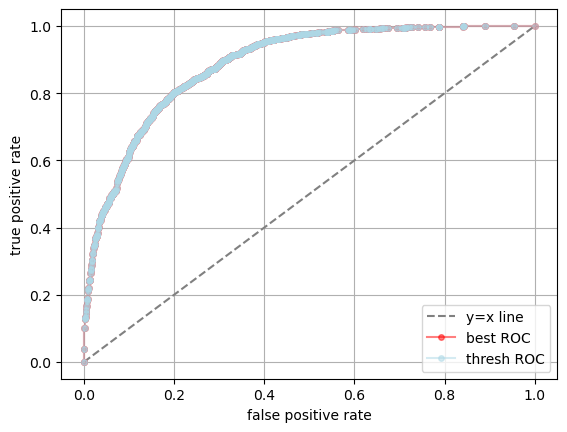

In [52]:
best_index_thresh = np.argmax(np.array(partial_aucs))
best_auc_thresh = aucs[best_index_thresh]
best_fpr_thresh = fprs[best_index_thresh]
best_tpr_thresh = tprs[best_index_thresh]
best_model = parameters[best_index_thresh]

best_index = np.argmax(np.array(aucs))
best_auc = aucs[best_index]
best_fpr = fprs[best_index]
best_tpr = tprs[best_index]

print('best ROC score:',best_auc)

# computing best Q
distances = np.zeros(len(best_fpr))

for i in range(len(best_fpr)):
    distances[i] = np.sqrt(best_fpr[i]**2+(1 - best_tpr[i])**2)

min_dist_idx = np.argmin(distances)


# Q = epsilon_gamma / sqrt(epsilon_hadron)
# epsilon_gamma = sel_gammas / tot_gammas = tpr
# epsilon_hadron = sel_hadrons / tot_hadrons = fpr

Q = tpr[min_dist_idx] / np.sqrt(fpr[min_dist_idx])

print('best ROC Q:',Q)


plt.grid()
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='y=x line')
plt.plot(best_fpr,best_tpr,marker='o',label='best ROC',ms=4,alpha=0.5,c='red')
plt.plot(best_fpr_thresh,best_tpr_thresh,marker='o',label='thresh ROC',ms=4,alpha=0.5,c='lightblue')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

In [53]:
#print(models.best_params_['hidden_layer_sizes'])
#best_model=MLPClassifier(activation = 'relu', hidden_layer_sizes = models.best_params_['hidden_layer_sizes'], learning_rate_init=models.best_params_['learning_rate_init'], max_iter = 200, alpha = 1e-4, solver = 'sgd',tol = 1e-4, learning_rate = 'adaptive')


best_model.fit(X_train,Y_train)
best_pred = best_model.predict(X_test)
accuracy = skm.accuracy_score(Y_test, best_pred)


AttributeError: 'list' object has no attribute 'fit'

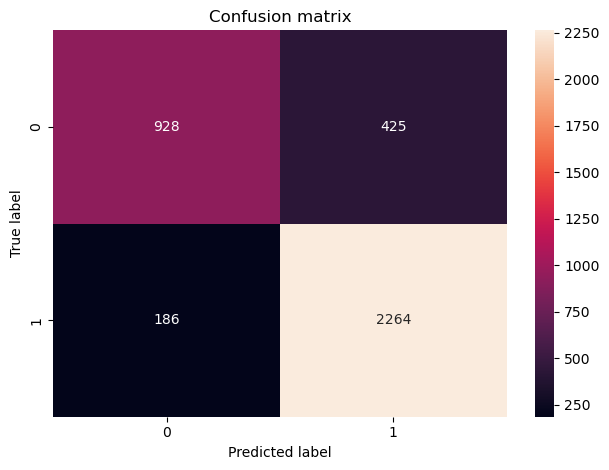

[CV] END ...hidden_layer_sizes=(36,), learning_rate_init=0.1; total time=   2.0s
[CV] END .hidden_layer_sizes=(36,), learning_rate_init=0.001; total time=   4.8s
[CV] END hidden_layer_sizes=(36, 18), learning_rate_init=0.01; total time=   2.8s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.01; total time=   5.5s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.1; total time=   3.8s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.001; total time=  11.0s
[CV] END ..hidden_layer_sizes=(18,), learning_rate_init=0.01; total time=   1.5s
[CV] END ..hidden_layer_sizes=(36,), learning_rate_init=0.01; total time=   3.2s
[CV] END ..hidden_layer_sizes=(54,), learning_rate_init=0.01; total time=   7.3s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.1; total time=   3.1s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.001; total time=   8.6s
[CV] END hidden_layer_sizes=(54, 36, 18), learning_rate_init=0.01; total time=   3.8s
[CV] END ...hidde

[CV] END ..hidden_layer_sizes=(18,), learning_rate_init=0.01; total time=   2.8s
[CV] END ......hidden_layer_sizes=54, learning_rate_init=0.1; total time=   2.1s
[CV] END ....hidden_layer_sizes=54, learning_rate_init=0.001; total time=   7.6s
[CV] END hidden_layer_sizes=(54, 18), learning_rate_init=0.01; total time=   5.3s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.01; total time=   6.8s
[CV] END hidden_layer_sizes=(54, 36, 18), learning_rate_init=0.01; total time=   7.5s
[CV] END .hidden_layer_sizes=(18,), learning_rate_init=0.001; total time=   3.8s
[CV] END ...hidden_layer_sizes=(54,), learning_rate_init=0.1; total time=   2.3s
[CV] END hidden_layer_sizes=(36, 18), learning_rate_init=0.1; total time=   5.3s
[CV] END hidden_layer_sizes=(36, 18), learning_rate_init=0.001; total time=   8.4s
[CV] END hidden_layer_sizes=(54, 36), learning_rate_init=0.001; total time=  11.8s
[CV] END .hidden_layer_sizes=(18,), learning_rate_init=0.001; total time=   6.5s
[CV] END hidden_l

In [16]:
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    sns.heatmap(conf_matrix, annot=True, fmt="d",)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

labels, freqs = np.unique(Y_test, return_counts=True) 
cm_NN = skm.confusion_matrix(Y_test, best_pred)
plot_conf_matrix(cm_NN)
